In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.comparison_tools import dataset_smart_read, distrib_score, spectral_score
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.spectral_tools import calc_ispec, coord, spectrum
from pyqg_generative.tools.computational_tools import PDF_histogram
%load_ext autoreload
%autoreload 3

# Idealized ocean model

In [2]:
ds = {}
for res in ['48', '64', '96', '256']:
    ds[res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc', delta=0.25)    

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc


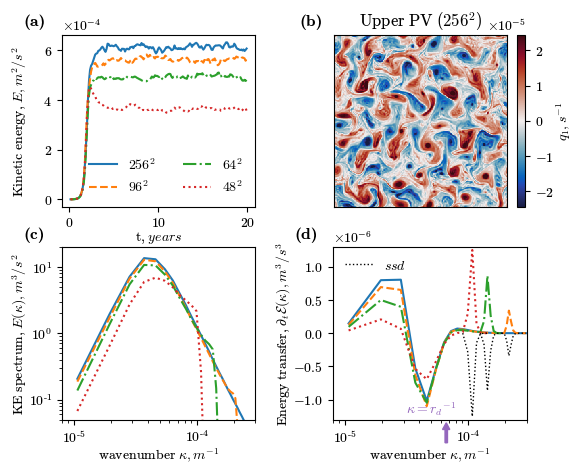

In [42]:
default_rcParams({})
matplotlib.rcParams.update({
    'figure.subplot.wspace': 0.4, 
    'figure.subplot.hspace': 0.23, 
    'figure.figsize': (6, 5),
    'axes.titlelocation' : 'center'})
ls = {'256': '-', '96': '--', '64': '-.', '48': ':'}

fig = plt.figure()

plt.subplot(2,2,1)
for res in ['256', '96', '64', '48']:
    ds[res].KE_time.plot(ls=ls[res], label=f'${res}^2$')
plt.ylabel(r'Kinetic energy, $E, m^2/s^2$')
plt.xlabel('t, $years$')
#plt.title('Kinetic energy')
plt.legend(ncol=2, frameon=False)

plt.subplot(2,2,2)
q = ds['256'].q.isel(time=-1,run=0,lev=0)
imshow(q, cbar_label='$q_1, s^{-1}$')
plt.title('Upper PV ($256^2$)')

plt.subplot(2,2,3)
for res in ['256', '96', '64', '48']:
    (0.5*ds[res].KEspecr_mean).plot(ls=ls[res])
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-2, 2e+1])
plt.xlim([8e-6,3e-4])
plt.ylabel('KE spectrum, $E(\kappa), m^3/s^2$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
#plt.title('KE spectrum')

plt.subplot(2,2,4)
for res in ['256', '96', '64', '48']:
    ds[res].Efluxr.plot(ls=ls[res])
flag = True
for res in ['256', '96', '64', '48']:
    idx = 0
    for i in range(len(ds[res].kr)):
        if ds[res].Dissspecr[i] < 0:
            idx = i-1
            break
    ds[res].Dissspecr[idx:].plot(color='k', ls=':', lw=1, label='$ssd$' if flag else None); flag=False
plt.xscale('log')
plt.xlim([8e-6,3e-4])
plt.ylim([-1.3e-6, 1.3e-6])
plt.ylabel(r'Energy transfer, $\partial_t \mathcal{E}(\kappa), m^3/s^3$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
#plt.title('Energy transfer')
#plt.legend(ncol=1, bbox_to_anchor=(1.47,1), loc='upper right')
plt.legend(frameon=False)
plt.arrow(1/15000, -1.65e-6, 0, +0.2e-6, width=3e-6, head_length=1e-7, clip_on=False, color='tab:purple')
plt.text(5e-5, -1.2e-6, '$\kappa={r_d}^{-1}$', color='tab:purple', horizontalalignment='center')

fig.align_ylabels()
set_letters()
plt.savefig('paper_figures_1/fig1_2_2.pdf')

# Subgrid forcing dataset

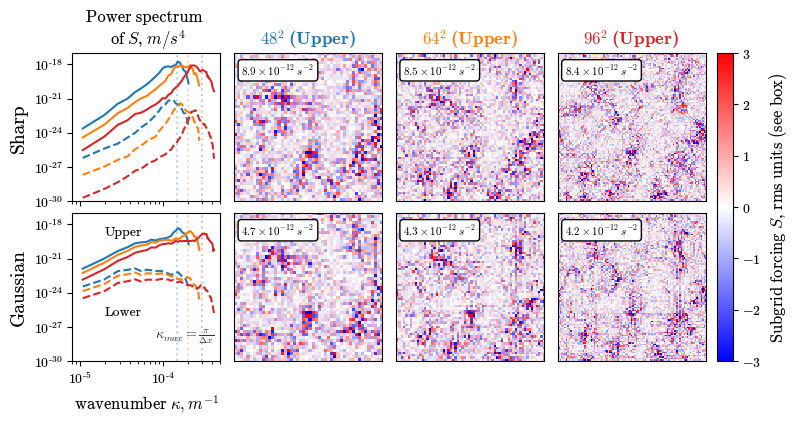

In [75]:
from cycler import cycler
default_rcParams({
    'axes.titlelocation' : 'center', 
    'axes.labelsize': 12,
    'axes.labelpad': 4,
    'axes.prop_cycle': cycler(color=['tab:blue', 'tab:orange', 'tab:red'])
    })
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc').q.isel(time=-1)
lev=0

vmax=3
    
fig, axs = plt.subplots(2,4,figsize=(10,4))
plt.subplots_adjust(hspace=0.08, wspace=0.0)
for j, (resolution, res_name) in enumerate(zip([48, 64, 96], ['$48^2$', '$64^2$', '$96^2$'])):
    for i, operator in enumerate([Operator1, Operator2]):   
        forcing = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator{str(i+1)}-{str(resolution)}/OLSModel-0/offline_test.nc').q_forcing_advection.isel(run=10, time=-1)
#        forcing = xr.DataArray(PV_subgrid_forcing(q.values, resolution, operator, EDDY_PARAMS)[0], dims=('lev', 'y', 'x'))
        
        sp = spectrum(time=slice(None,None))(forcing.expand_dims('time'))
        line = axs[i][0].loglog(sp.k, sp.isel(lev=0).values, label=res_name)
        axs[i][0].loglog(sp.k, sp.isel(lev=1).values, color=line[0].get_color(), ls='--')
        axs[i][0].set_box_aspect(1)
        axs[i][0].set_ylim([1e-30,1e-17])
        axs[i][0].set_xlim([8e-6, 5e-4])
        dx = 1e+6 / resolution
        axs[i][0].axvline(x=np.pi / dx, color=line[0].get_color(), ls=':', alpha=0.3)
        
        ax = axs[i][j+1]
        im = imshow(forcing.isel(lev=lev), vmax=vmax, ax=ax, cbar=False, cmap='bwr', normalize=True, normalize_postfix='$s^{-2}$')
        if i==0:
            ax.set_title(res_name+' (Upper)', color=line[0].get_color(), fontweight='bold')

#        if i==1:
#            axs[i][0].legend(ncol=1, fontsize=8)
axs[1][0].text(2e-5, 1e-26, 'Lower')
axs[1][0].text(2e-5, 1e-19, 'Upper')
axs[1][0].text(8e-5, 1e-28, r'$\kappa_{max}=\frac{\pi}{\Delta x}$', alpha=0.8)
#cbar = plt.colorbar(im, ax=axs, label='Subgrid forcing $S$, $1/s^2$')
cbar = plt.colorbar(im, ax=axs, label='Subgrid forcing $S$, rms units (see box)', pad=0.015)
axs[1][0].set_xlabel(r'wavenumber $\kappa, m^{-1}$')
axs[0][0].set_title('Power spectrum \n of $S$, $m/s^4$')
axs[0][0].set_ylabel('Sharp', fontsize=14)
axs[1][0].set_ylabel('Gaussian', fontsize=14)
axs[0][0].set_xticklabels([])
fig.align_ylabels()
plt.savefig('paper_figures_1/subgrid_forcing_upper.pdf')

# Visual analysis of predictions

In [3]:
def plot_stochastic_prediction(resolution=96, operator='Operator2', lev=1, v_total=3, v_std=2, v_residual=3, run=10, time=-1):
    default_rcParams({'axes.titlelocation' : 'center'})

    cbar_prms = {'normalize': True, 'cbar': False}
    
    fig, axs = plt.subplots(3,5,figsize=(10,6))
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+operator+'-'+str(resolution)+'/MeanVarModel-3/offline_test.nc').isel(run=run,time=time,lev=lev)
    gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+operator+'-'+str(resolution)+'/CGANRegression-retrain-0/offline_test.nc').isel(run=run,time=time,lev=lev)
    vae = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+operator+'-'+str(resolution)+'/CVAERegression-None-4/offline_test.nc').isel(run=run,time=time,lev=lev)

    for row, model in enumerate([gz, gan, vae]):
        if row ==1:
            imshow(model.q_forcing_advection, ax = axs[row][0], cmap='bwr', vmax=v_total, normalize_postfix='$s^{-2}$', **cbar_prms)
        else:
            axs[row][0].remove()
        im_mean = imshow(model.q_forcing_advection_mean, ax = axs[row][1], cmap='bwr', vmax=v_total, normalize_postfix='$s^{-2}$', **cbar_prms)
        im_std = imshow(model.q_forcing_advection_std, ax = axs[row][2], cmap=cmocean.cm.balance, vmax=v_std, normalize_postfix='$s^{-2}$', **cbar_prms)
        im_res = imshow((model.q_forcing_advection_res), ax = axs[row][3], cmap='viridis', vmax=v_residual, normalize_postfix='$s^{-2}$', **cbar_prms)
        imshow((model.q_forcing_advection_gen_res), ax = axs[row][4], cmap='viridis', vmax=v_residual, normalize_postfix='$s^{-2}$', **cbar_prms)

    axs[1][0].set_title('Subgrid forcing \n $S$')
    axs[0][1].set_title('Model mean \n $\mathrm{E}(\widetilde{S}|\overline{q})$')
    axs[0][2].set_title('Model std \n $\mathrm{Std}(\widetilde{S}|\overline{q})$')
    axs[0][3].set_title('True residual \n $r = S-\mathrm{E}(\widetilde{S}|\overline{q})$')
    axs[0][4].set_title('Simulated residual \n $\widetilde{r} = \widetilde{S} - \mathrm{E}(\widetilde{S}|\overline{q})$')

    plt.colorbar(im_mean, cax=fig.add_axes([0.15,0.08,0.26,0.02]), orientation='horizontal', label='rms units (see box)')
    plt.colorbar(im_std, cax=fig.add_axes([0.447,0.08,0.13,0.02]), orientation='horizontal', label='rms units')
    plt.colorbar(im_res, cax=fig.add_axes([0.61,0.08,0.27,0.02]), orientation='horizontal', label='rms units')

    fig.text(0.91,0.75,'GZ', fontsize=14)
    fig.text(0.91,0.485,'GAN', fontsize=14)
    fig.text(0.91,0.23,'VAE', fontsize=14)

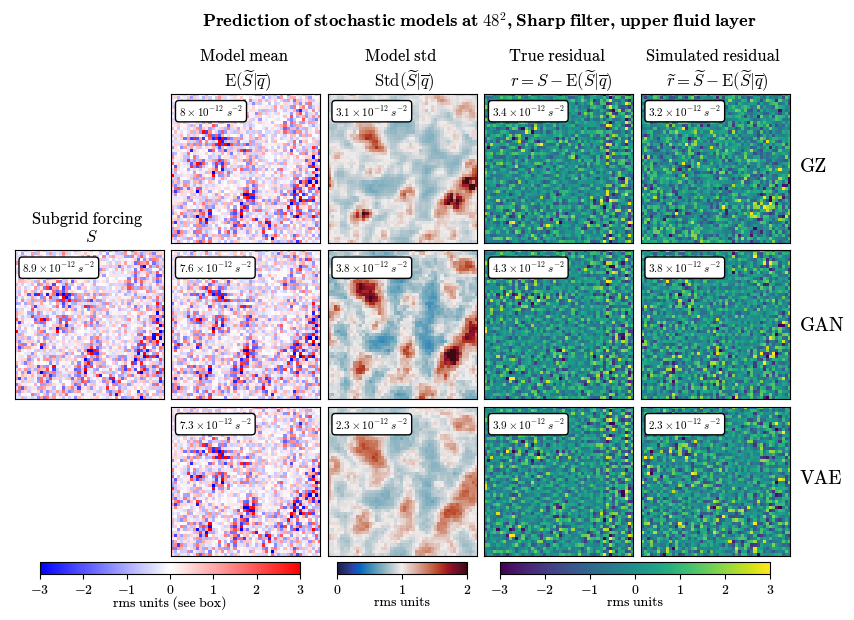

In [4]:
plot_stochastic_prediction(operator='Operator1', resolution=48, lev=0)
plt.suptitle('Prediction of stochastic models at $48^2$, Sharp filter, upper fluid layer', y=1.02, x=0.59, fontweight='bold')
plt.savefig(f'paper_figures_1/offline_snapshot_op1_48_upper.pdf')

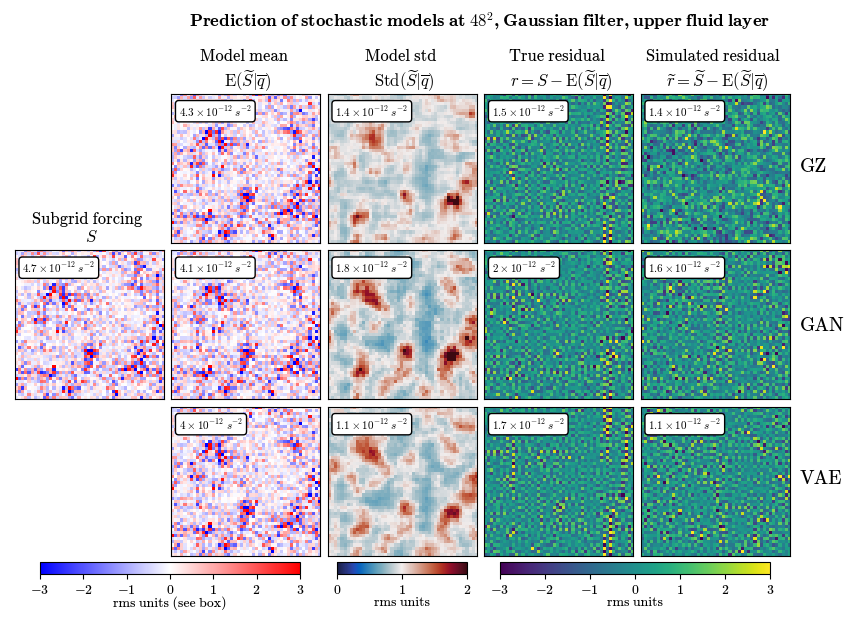

In [5]:
plot_stochastic_prediction(operator='Operator2', resolution=48, lev=0)
plt.suptitle('Prediction of stochastic models at $48^2$, Gaussian filter, upper fluid layer', y=1.02, x=0.59, fontweight='bold')
plt.savefig(f'paper_figures_1/offline_snapshot_op2_48_upper.pdf')

## Additional figures

Text(0.59, 1.02, 'Prediction of stochastic models at $96^2$, Sharp filter, lower fluid layer')

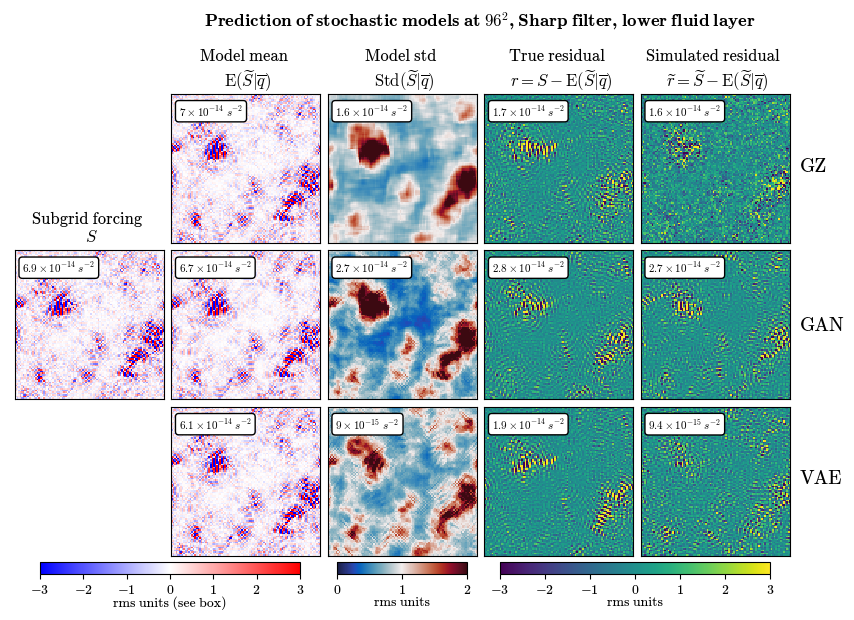

In [8]:
plot_stochastic_prediction(operator='Operator1', resolution=96, lev=1)
plt.suptitle('Prediction of stochastic models at $96^2$, Sharp filter, lower fluid layer', y=1.02, x=0.59, fontweight='bold')

Text(0.59, 1.02, 'Prediction of stochastic models at $96^2$, Gaussian filter, lower fluid layer')

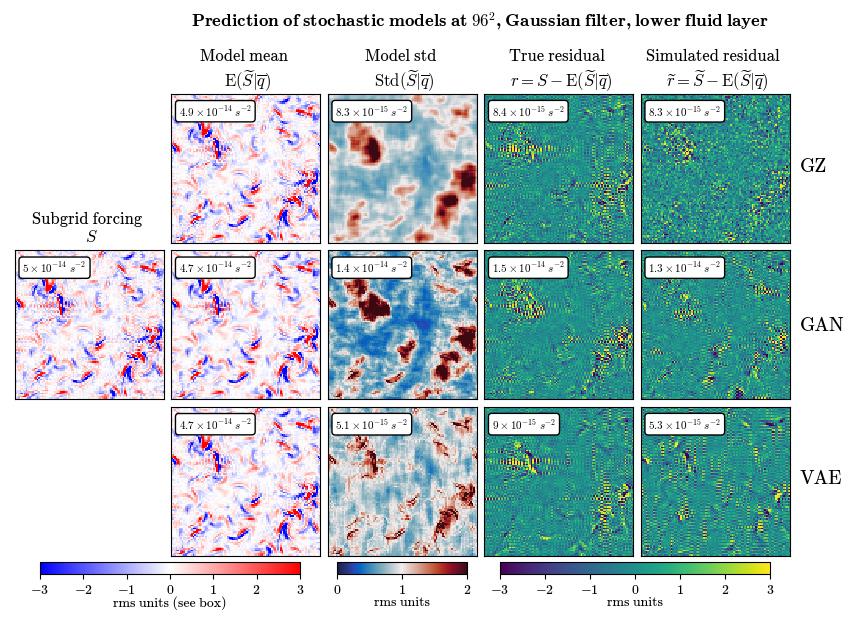

In [7]:
plot_stochastic_prediction(operator='Operator2', resolution=96, lev=1)
plt.suptitle('Prediction of stochastic models at $96^2$, Gaussian filter, lower fluid layer', y=1.02, x=0.59, fontweight='bold')

# Power spectrum

In [4]:
def reader(path):
    ds = xr.open_dataset(path)
#    return ds
    time = slice(44,None)    
    ds = ds.drop_vars(('PDF0', 'PDF1', 'PDF_gen0', 'PDF_gen1', 'PDF_mean0', 'PDF_mean1', 
                       'PDF_res0', 'PDF_res1', 'PDF_gen_res0', 'PDF_gen_res1', 'q_0', 'q_1'))
    
    time = slice(44,None)
    Nbins = 70
    target = 'q_forcing_advection'
    for lev in [0,1]:
        arr = ds[target].isel(time=time, lev=lev)
        mean, std = arr.mean(), arr.std()
        xmin = -5; xmax = 5
        coords = None
        for suffix in ['', '_gen', '_mean']:
            array = ds[target+suffix].isel(time=time, lev=lev).values.ravel() / float(std)
            points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
            if coords is None:
                coords=[coord(points, 'RMS units')]
                
            ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='q_'+str(lev), coords=coords)
    
    for lev in [0,1]:
        arr = ds[target+'_res'].isel(time=time, lev=lev)
        mean, std = arr.mean(), arr.std()
        xmin = -5; xmax = 5
        coords = None
        for suffix in ['_res', '_gen_res']:
            array = ds[target+suffix].isel(time=time, lev=lev).values.ravel() / float(std)
            points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
            if coords is None:
                coords=[coord(points, 'RMS units')]
            ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='dq_'+str(lev), coords=coords)
    
    return ds

In [20]:
def plot_spectra(operator='Operator2', resolution=96, lev=0, gan_folder='CGANRegression', gz_model='0', gan_model='0', vae_model='0', ds=False):
    default_rcParams({
    'lines.linewidth': 1.5,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 14,
    'lines.markersize': 2
})
    cl = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
#    lss = ['-', '--', '-.', ':']
    lss = ['-', '-', '-', '-']
    mks = ['d', 'o', None, None]

    mse = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+operator+'-'+str(resolution)+f'/OLSModel-{gz_model}/offline_test.nc').isel(lev=lev)
    gz = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+operator+'-'+str(resolution)+f'/MeanVarModel-{gz_model}/offline_test.nc').isel(lev=lev)
    gan = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+operator+'-'+str(resolution)+f'/{gan_folder}-{gan_model}/offline_test.nc').isel(lev=lev)
    vae = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/'+operator+'-'+str(resolution)+f'/CVAERegression-None-{vae_model}/offline_test.nc').isel(lev=lev)
    
    if ds:
        return mse, gz, gan, vae

    fig, axs = plt.subplots(2,2, figsize=(10,5))
    plt.subplots_adjust(wspace=0.3, hspace=0.35)

    ax = axs[1][0]
    mse.Eflux.plot(ax=ax, color='k', ls='--', lw=3, label='True')
    for m, color, ls, mk, label in zip([mse, gz, gan, vae], cl, lss, mks, ['MSE', 'GZ', 'GAN', 'VAE']):
        m.Eflux_gen.plot(ax=ax, color=color, label=label, ls=ls, marker=mk)
    ax.set_title('')
    ax.set_ylabel('Energy transfer \n by subgrid forcing, $m^3/s^3$')

    ax = axs[0][1]
    mse.PSD.plot(ax=ax, color='k', ls='--', lw=3, label='True')
    for m, color, ls, mk, label in zip([mse, gz, gan, vae], cl, lss, mks, ['MSE', 'GZ', 'GAN', 'VAE']):
        m.PSD_gen.plot(ax=ax, color=color, ls=ls, label=label, marker=mk)
    ax.set_title('')
    ax.set_ylabel('Power spectrum of \n subgrid forcing, $sp(S), m/s^4$')
    ax.legend(fontsize=11, frameon=False)


    ax = axs[0][0]
    gan.PSD_res.plot(ax=ax, ls='--', color='k', lw=3)
    gz.PSD_gen_res.plot(ax=ax, color=cl[1], ls=lss[1], marker=mks[1])
    gan.PSD_gen_res.plot(ax=ax, color=cl[2], ls=lss[2], marker=mks[2])
    vae.PSD_gen_res.plot(ax=ax, color=cl[3], ls=lss[3], marker=mks[3])
    ax.set_title('')
    ax.set_ylabel('Power spectrum of \n residuals, $sp(r), m/s^4$')

    ax = axs[1][1]
    if lev==0:
        key_ref = 'PDF0'
        key = 'PDF_gen0'
    else:
        key_ref = 'PDF1'
        key = 'PDF_gen1'
    
    mse[key_ref].plot(ax=ax, color='k', ls='--', lw=3)
    for m, color, ls, mk in zip([mse, gz, gan, vae], cl, lss, mks):
        m[key].plot(ax=ax, color=color, ls=ls, marker=mk)
    ax.set_title('')
    ax.set_ylabel('PDF density of \n subgrid forcing $S$')
    ax.set_xlabel('RMS units')
    ax.set_yscale('log')

    for inset, xlim, ylim in zip(
        [[0.7, 0.55, 0.4, 0.5], [0.7, -0.05, 0.4, 0.5]],
#        [[0.55, 0.1, 0.4, 0.5]],
        [[-1, 1], [-3, -2]],
#        [[-3, -2]],
        [[0.3, 0.7], [5e-3,5e-2]]
#        [[5e-3,5e-2]]
        ):
        ax_inset = ax.inset_axes(inset)
        mse[key_ref].plot(ax=ax_inset, color='k', ls='-', lw=3)
        for m, color, ls, mk in zip([mse, gz, gan, vae], cl, lss, mks):
            m[key].plot(ax=ax_inset, color=color, ls=ls, marker=mk)
        ax_inset.set_xlabel('')
        ax_inset.set_ylabel('')
        ax_inset.set_xticklabels([])
        ax_inset.set_yticklabels([])
        ax_inset.set_title('')
        ax_inset.set_xlim(xlim)
        ax_inset.set_ylim(ylim)
#        ax_inset.set_yscale('log')
        ax.indicate_inset_zoom(ax_inset, edgecolor="black")
        
#        if operator=='Operator2':
#            ax_inset.set_xlim([-0.3e-11, 0.3e-11])
#            ax_inset.set_ylim([0.8e+11, 1.6e+11])
#        else:
#            ax_inset.set_xlim([-0.6e-11, 0.6e-11])
#            ax_inset.set_ylim([0.4e+11, 0.8e+11])


    dx = gan.x[2] - gan.x[1]
    for i in [0,1]:
        for j in [0,1]:
            if i==1 and j==1:
                break
            axs[i][j].axvline(x=np.pi/dx, ls='--', color='gray', lw=1)
            if operator == 'Operator1':
                axs[i][j].axvline(x=0.65*np.pi/dx, ls='-.', color='gray', lw=1)
    if lev==0:
        if operator == 'Operator2':
            axs[1][0].text(np.pi/dx, 2e-6, r'$\frac{\pi}{\Delta x}$', fontsize=14, color='gray')
        else:
            axs[1][0].text(np.pi/dx, 2e-6, r'$\frac{\pi}{\Delta x}$', fontsize=12, color='gray')
            axs[1][0].text(0.65*np.pi/dx, 2e-6, r'$0.65\frac{\pi}{\Delta x}$', fontsize=12, color='gray')

    for j in [0,1]:
        xlim = list(axs[0][0].get_xlim())
        xlim[0] = -0.1e-4
        if resolution == 48:
            xticks = [0, 0.00005, 0.0001, 0.00015, 0.0002]
        else:
            xticks = [0, 0.0001, 0.0002, 0.0003, 0.0004]
        axs[0][j].set_xticks(xticks)
        axs[0][j].set_xlim(xlim)
        axs[0][j].set_xlabel('wavenumber $\kappa, m^{-1}$')
        axs[1][0].set_xticks(xticks)
        axs[1][0].set_xlim(xlim)
        axs[1][0].set_xlabel('wavenumber $\kappa, m^{-1}$')
    
        
    fig.align_ylabels(axs[:,0])
    fig.align_ylabels(axs[:,1])
    
    set_letters(x=-0.07)
    return axs

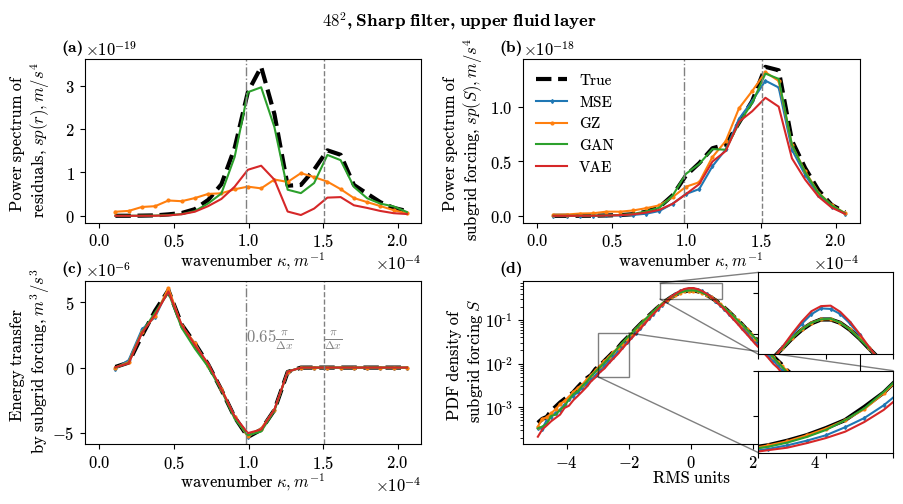

In [21]:
plot_spectra(operator='Operator1', resolution=48, lev=0, gan_folder='CGANRegression-retrain', gan_model=2);
plt.suptitle('$48^2$, Sharp filter, upper fluid layer', fontweight='bold')
plt.savefig('figures/offline_retrain_48.pdf')

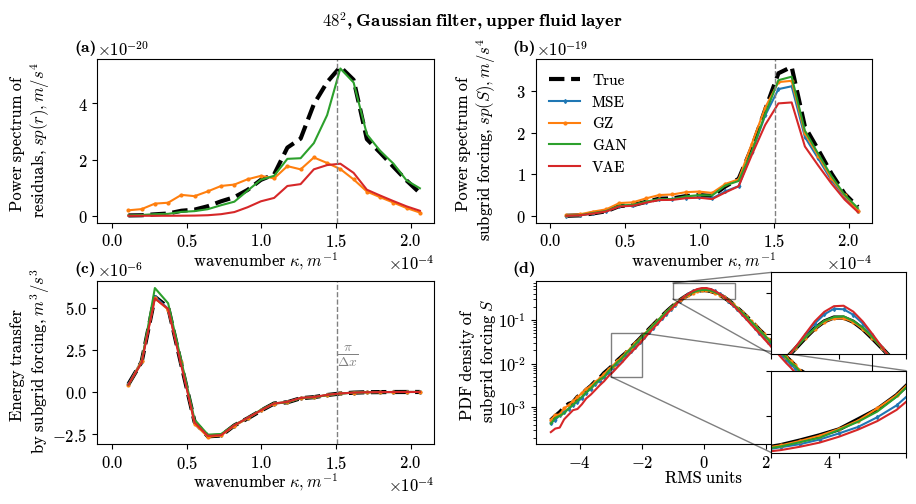

In [22]:
plot_spectra(operator='Operator2', resolution=48, lev=0, gan_folder='CGANRegression-retrain', gan_model=2);
plt.suptitle('$48^2$, Gaussian filter, upper fluid layer', fontweight='bold')
plt.savefig('figures/offline_retrain_48_gauss.pdf')

## Additional figures

Text(0.5, 0.98, '$96^2$, Sharp filter, upper fluid layer')

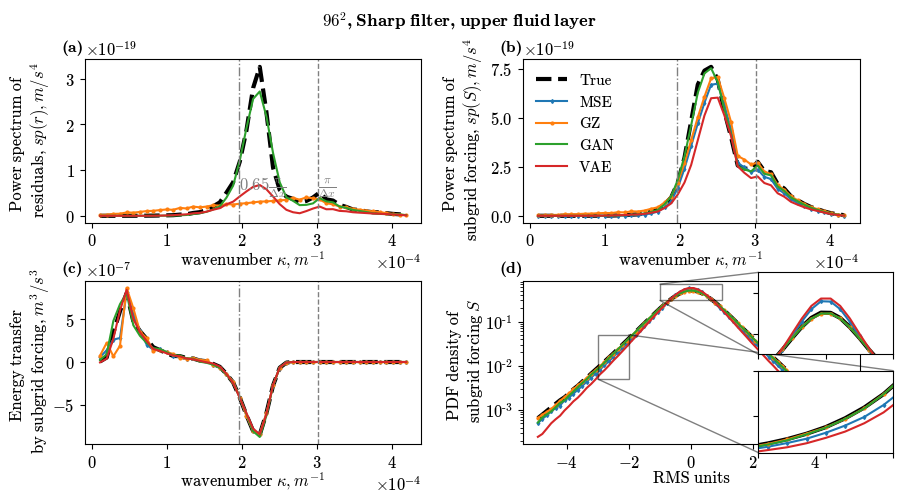

In [23]:
plot_spectra(operator='Operator1', gan_folder='CGANRegression-retrain', gan_model=2);
plt.suptitle('$96^2$, Sharp filter, upper fluid layer', fontweight='bold')
#plt.savefig('paper_figures_1/offline_retrain.pdf')

Text(0.5, 0.98, '$96^2$, Gaussian filter, upper fluid layer')

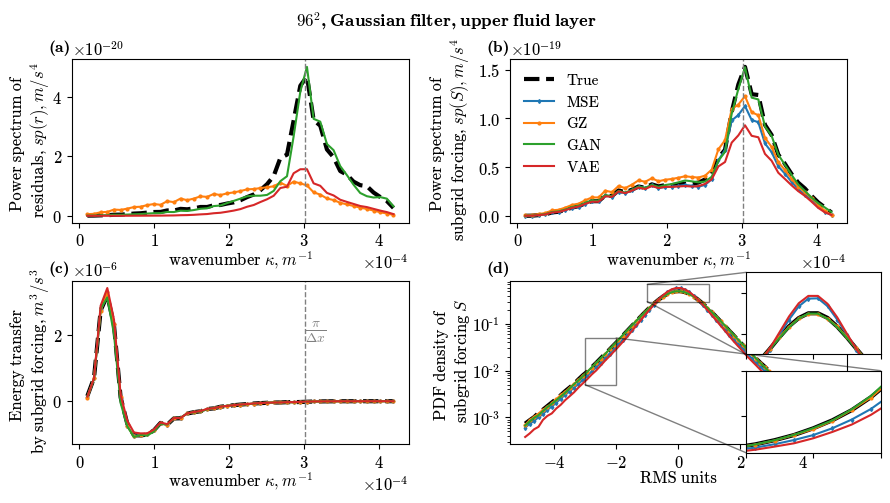

In [24]:
plot_spectra(gan_folder='CGANRegression-retrain', gan_model=2);
plt.suptitle('$96^2$, Gaussian filter, upper fluid layer', fontweight='bold')
#plt.savefig('paper_figures_1/offline_retrain.pdf')

# Metrics for offline analysis

In [25]:
def read_metric(metric='L2_mean', model='OLSModel', model_num=0, resolution=64, operator='Operator1', exp='offline_test.nc', folder='models_retrain'):
    file = os.path.join('/scratch/pp2681/pyqg_generative/Reference-Default-scaled', folder, operator+'-'+str(resolution),model+'-'+str(model_num),exp)
    if os.path.exists(file):
        ds = xr.open_dataset(file)
        return float(ds[metric].mean())
    else:
        print('Wrong path', file)

In [26]:
def read_line(**kw):
    res = [48, 64, 96]
    y = np.array([[read_metric(model_num=j, resolution=r, **kw) for j in range(5)] for r in res])
    res = xr.DataArray(res)
    trial = xr.DataArray(np.arange(5))
    y = xr.DataArray(y, dims=['res', 'trial'], coords=[res, trial])
    outlier = y * np.nan
    if kw['operator'] == 'Operator1' and kw['model'] in ['OLSModel', 'MeanVarModel', 'CGANRegression']:
        outlier[0,3] = y[0,3]
        y[0,3] = np.nan
    if kw['operator'] == 'Operator1' and kw['model'] in ['CVAERegression-None']:
        outlier[1,2:4] = y[1,2:4]
        y[1,2:4] = np.nan
    
    q25 = y.quantile(0.25, dim='trial', skipna=True).drop_vars('quantile')
    q50 = y.quantile(0.5, dim='trial', skipna=True).drop_vars('quantile')
    q75 = y.quantile(0.75, dim='trial', skipna=True).drop_vars('quantile')
    q0 = y.min(dim='trial', skipna=True)
    q100 = y.max(dim='trial', skipna=True)
    return xr.Dataset({'data': y, 'outlier': outlier, 'q25': q25, 'q50': q50, 'q75': q75, 'q0': q0, 'q100': q100})

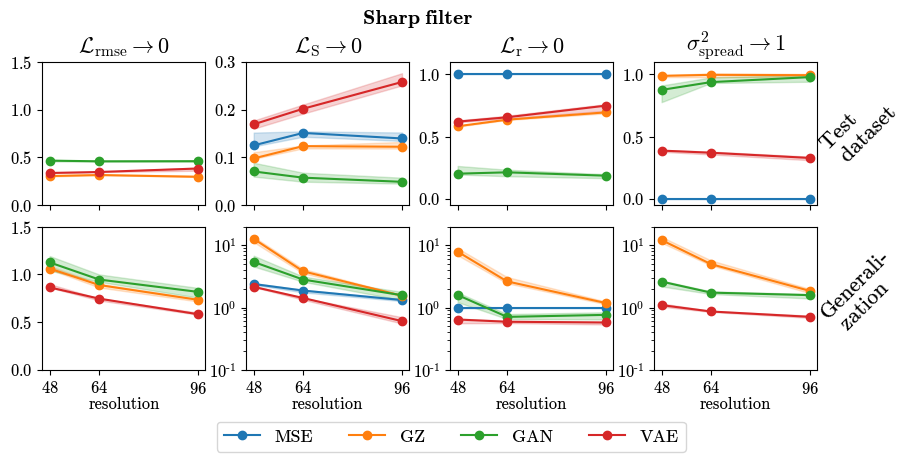

In [27]:
default_rcParams({
    'axes.formatter.limits': (-2,2),
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 12,
    'axes.titlelocation' : 'center'})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, axs = plt.subplots(2,4,figsize=(10,4))
plt.subplots_adjust(hspace=0.15, wspace=0.25)
operator = 'Operator1'
for i, exp in enumerate(['offline_test.nc', 'offline_transfer.nc']):
    for j, (model, label) in enumerate(zip(['OLSModel', 'MeanVarModel', 'CGANRegression-retrain', 'CVAERegression-None'], ['MSE', 'GZ', 'GAN', 'VAE'])):
        res = [48, 64, 96]
        for col, metric in enumerate(['L2_mean', 'L2_total', 'L2_residual', 'var_ratio']):
            ds= read_line(metric=metric, model=model, operator=operator, exp=exp)
            ax = axs[i][col]
            if metric != 'L2_mean' or label != 'MSE':                
                ax.plot(res, ds.q50, color=colors[j], marker='o', label=label)
                ax.fill_between(res, ds.q0, ds.q100, color=colors[j], alpha=0.2)
            
#             limits = {'L2_mean': 1.5, 'L2_total': 2e+1, 'L2_residual': 2e+1, 'var_ratio': 2e+1}
#             for r in res:
#                 if model in ['CVAERegression-None', 'MeanVarModel']:
#                     outliers = ds.outlier.sel(res=r)
#                     for outlier in outliers:
#                         if i==1:
#                             outlier = max(min(outlier, limits[metric]), 5e-1)
#                         ax.plot(r, outlier, color=colors[j], marker='d', markeredgecolor='k', zorder=10, clip_on=False)
        
for j in range(4):
    axs[1][j].set_xlabel('resolution')
    axs[0][j].set_xticks([48, 64, 96])
    axs[1][j].set_xticks([48, 64, 96])
    axs[0][j].set_xticklabels([])
    
axs[0][0].set_ylim([0.0, 1.5])
axs[0][1].set_ylim([0, 0.3])
axs[0][2].set_ylim([-0.05, 1.1])
axs[0][3].set_ylim([-0.05, 1.1])

for j in range(4):
    if j > 0:
        axs[1][j].set_ylim([1e-1, 2e+1])
        axs[1][j].set_yscale('log')
    else:
        axs[1][j].set_ylim([0.0, 1.5])
    
axs[0][0].set_title(r'$\mathcal{L}_{\mathrm{rmse}} \rightarrow 0$')
axs[0][1].set_title(r'$\mathcal{L}_{\mathrm{S}} \rightarrow 0$')
axs[0][2].set_title(r'$\mathcal{L}_{\mathrm{r}} \rightarrow 0$')
axs[0][3].set_title(r'$\sigma^2_{\mathrm{spread}} \rightarrow 1$')


# axs[0][1].plot(np.nan,np.nan,ls='',marker='d',markeredgecolor='k', color='tab:red', label='posterior \n collapse')
# axs[0][1].plot(np.nan,np.nan,ls='',marker='d',markeredgecolor='k', color='tab:orange', label='generaliz. \n outlier')
#axs[0][1].legend(bbox_to_anchor=(-1.55,1), fontsize=13)
axs[1][2].legend(bbox_to_anchor=(1.5,-0.3), ncol=4, fontsize=13)

fig.text(0.9, 0.62, 'Test \n dataset', fontsize=16, rotation=45)
fig.text(0.9, 0.2, 'Generali-\n zation', fontsize=16, rotation=45)
plt.suptitle('Sharp filter', y=1.01, fontweight='bold', fontsize=14)
plt.savefig('figures/offline_metrics_sharp_retrain_new_colorbar.pdf')

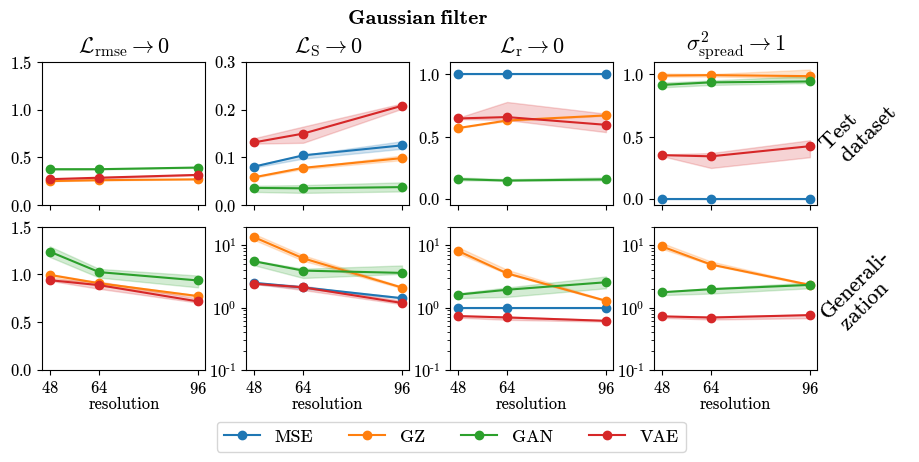

In [28]:
default_rcParams({
    'axes.formatter.limits': (-2,2),
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 12,
    'axes.titlelocation' : 'center'})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, axs = plt.subplots(2,4,figsize=(10,4))
plt.subplots_adjust(hspace=0.15, wspace=0.25)
operator = 'Operator2'
for i, exp in enumerate(['offline_test.nc', 'offline_transfer.nc']):
    for j, (model, label) in enumerate(zip(['OLSModel', 'MeanVarModel', 'CGANRegression-retrain', 'CVAERegression-None'], ['MSE', 'GZ', 'GAN', 'VAE'])):
        res = [48, 64, 96]
        for col, metric in enumerate(['L2_mean', 'L2_total', 'L2_residual', 'var_ratio']):
            ds= read_line(metric=metric, model=model, operator=operator, exp=exp)
            ax = axs[i][col]
            if metric != 'L2_mean' or label != 'MSE':                
                ax.plot(res, ds.q50, color=colors[j], marker='o', label=label)
                ax.fill_between(res, ds.q0, ds.q100, color=colors[j], alpha=0.2)

for j in range(4):
    axs[1][j].set_xlabel('resolution')
    axs[0][j].set_xticks([48, 64, 96])
    axs[1][j].set_xticks([48, 64, 96])
    axs[0][j].set_xticklabels([])
    
axs[0][0].set_ylim([0.0, 1.5])
axs[0][1].set_ylim([0, 0.3])
axs[0][2].set_ylim([-0.05, 1.1])
axs[0][3].set_ylim([-0.05, 1.1])

for j in range(4):
    if j > 0:
        axs[1][j].set_ylim([1e-1, 2e+1])
        axs[1][j].set_yscale('log')
    else:
        axs[1][j].set_ylim([0.0, 1.5])
    
axs[0][0].set_title(r'$\mathcal{L}_{\mathrm{rmse}} \rightarrow 0$')
axs[0][1].set_title(r'$\mathcal{L}_{\mathrm{S}} \rightarrow 0$')
axs[0][2].set_title(r'$\mathcal{L}_{\mathrm{r}} \rightarrow 0$')
axs[0][3].set_title(r'$\sigma^2_{\mathrm{spread}} \rightarrow 1$')

#axs[0][1].legend(bbox_to_anchor=(-1.55,1), fontsize=13)
axs[1][2].legend(bbox_to_anchor=(1.5,-0.3), ncol=4, fontsize=13)

fig.text(0.9, 0.62, 'Test \n dataset', fontsize=16, rotation=45)
fig.text(0.9, 0.2, 'Generali-\n zation', fontsize=16, rotation=45)
plt.suptitle('Gaussian filter', y=1.01, fontweight='bold', fontsize=14)
plt.savefig('figures/offline_metrics_retrain_new_colorbar.pdf')

## Generalization to transitional flow

In [13]:
def read_line(model='OLSModel', operator='Operator1', res=48, trial=0):
    model = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/{operator}-{str(res)}/{model}-{str(trial)}/offline_test.nc', decode_times=False).astype('float64')
    model['time'] = model['time'] / 360
    
    stats = xr.Dataset()
    stats['rmse'] = np.sqrt(((model.q_forcing_advection_mean - model.q_forcing_advection)**2).mean(('x','y','run')))
    stats['sgs'] = np.sqrt((model.q_forcing_advection**2).mean(('x','y','run')))
    
    return stats

In [14]:
def read_trials(**kw):
    ds = []
    for trial in range(5):
        ds.append(read_line(trial=trial, **kw))
    ds = xr.concat(ds, dim='trial')
    return ds

In [15]:
gz = read_trials(model='MeanVarModel')
gan = read_trials(model='CGANRegression-retrain')
vae = read_trials(model='CVAERegression-None')

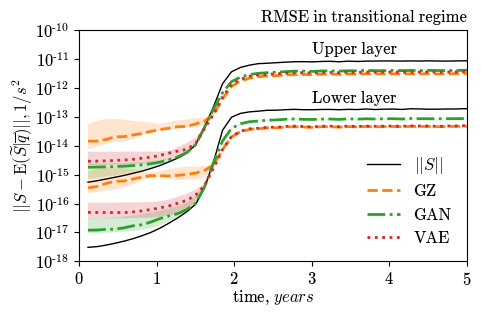

In [16]:
default_rcParams({
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
})
fig = plt.figure(figsize=(5,3))
colors = ['tab:orange', 'tab:green', 'tab:red']
labels = ['GZ', 'GAN', 'VAE']
ls = ['--', '-.', ':']

for lev in [0,1]:
    plt.subplot(1,1,1)
    gz['sgs'].isel(trial=0,lev=lev).plot(color='k', lw=1, ls='-', label='$||S||$' if lev==0 else None)
    for j, m in enumerate([gz, gan, vae]):
        m.rmse.isel(lev=lev).median('trial').plot(color=colors[j], label=labels[j] if lev==0 else None, ls=ls[j], lw=2)
        plt.fill_between(m.time, m.rmse.isel(lev=lev).min('trial'), m.rmse.isel(lev=lev).max('trial'), alpha=0.2, color=colors[j], edgecolor=None)
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.xlim([-0.1, 4])
    plt.ylabel('$||S-\mathrm{E}(\widetilde{S}|\overline{q})||, 1/s^2$')
    plt.xlabel('time, $years$')
plt.title('RMSE in transitional regime')
plt.xlim([0,5])
plt.ylim([1e-18, 1e-10])
plt.text(3, 1.5e-11, 'Upper layer')
plt.text(3, 3e-13, 'Lower layer')
plt.yticks([1e-18, 1e-17, 1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10])
plt.savefig('paper_figures_1/transitional_retrain.pdf')

# Time sampling method

In [35]:
def line_tau(operator='Operator1', res=48, model='MeanVarModel', conf='eddy', fun=distrib_score):
    tau_str = ['0', '12', '24', '36', '48']
    tau = [4, 12, 24, 36, 48]
    data = xr.DataArray(np.nan * np.zeros((5,5)), dims=['tau', 'trial'], coords={'tau': tau})
    for i, key in enumerate(tau_str):
        for j in range(5):
            if res==48 and operator == 'Operator1' and model in ['OLSModel', 'MeanVarModel', 'CGANRegression'] and j==3:
                continue
            
            try:
#                 print(f'{operator}-{str(res)}/{model}-{str(j)}/{conf}-AR1-{key}')
                data[i][j] = fun(distance[f'{operator}-{str(res)}/{model}-{str(j)}/{conf}-AR1-{key}'])
            except:
                pass
    return data
        

In [61]:
gz = line_tau(model='MeanVarModel')
gan = line_tau(model='CGANRegression-retrain')
vae = line_tau(model='CVAERegression-None')
lores = 0*gz['tau'] + distrib_score(distance['Operator1-48/Reference/eddy'])

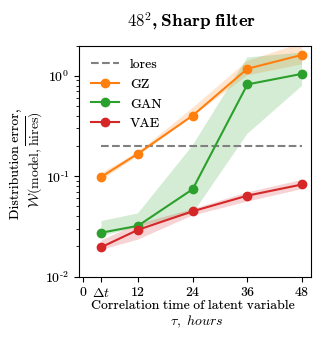

In [64]:
default_rcParams({'axes.formatter.limits': (-2,2)})
plt.figure(figsize=(3,3))
colors = ['tab:orange', 'tab:green', 'tab:red']
labels = ['GZ', 'GAN', 'VAE']
lores.plot(ls='--', color='gray', label='lores')
for j, m in enumerate([gz, gan, vae]):
    m.median('trial').plot(marker='o', label=labels[j], color=colors[j])
    plt.fill_between(m['tau'], m.min('trial'), m.max('trial'), color=colors[j], alpha=0.2, edgecolor=None)
plt.xticks([0, 4,12,24,36,48], ['0', '$\Delta t$', '12', '24', '36', '48'])
plt.xlim([-1, 50])
plt.ylim([1e-2, 2])
plt.legend(frameon=False)
plt.xlabel('Correlation time of latent variable \n $\\tau,~ hours$')
plt.title('')
plt.ylabel('Distribution error, \n $\mathcal{W}(\mathrm{model}, \overline{\mathrm{hires}})$')
plt.suptitle('$48^2$, Sharp filter', y=1.0, fontweight='bold')
plt.yscale('log')
plt.savefig('paper_figures_1/correlation_time.pdf')

# Results

In [29]:
def plot_online(operator='Operator1', resolution=48, exp='eddy-7200-constant-0', ref='reference_7200_48', delta=0.25, read_cache=True):
    def read_experiment(model='OLSModel', model_num=0, resolution=64, operator='Operator1', exp=exp, read_cache=read_cache, delta=delta):
        folder = os.path.join('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain', operator+'-'+str(resolution),model+'-'+str(model_num),exp)
        path = os.path.join(folder,'[0-9].nc')

        keyphrase = 'Warning: CFL>1. Computations are stopped.'
        err = os.path.join(folder, '*err*')
        os.system(f'cat {err} | grep "{keyphrase}"')

        ds = dataset_smart_read(path, read_cache=read_cache, delta=delta)
        return ds.isel(time=slice(0,None,2))

    def collapse_trials(**kw):
        ds = []
        for j in range(5):
            if kw['resolution']==48 and kw['operator'] == 'Operator1' and kw['model'] in ['OLSModel', 'MeanVarModel', 'CGANRegression'] and j==3:
                continue
            if kw['resolution']==64 and kw['operator'] == 'Operator1' and kw['model'] in ['CVAERegression-None'] and j in [2,3]:
                continue
            if kw['resolution']==96 and kw['operator'] == 'Operator1' and kw['model'] in ['CVAERegression-None'] and j in [4]:
                continue
            if kw['resolution']==96 and kw['operator'] == 'Operator2' and kw['model'] in ['CGANRegression-retrain'] and j in [1, 3, 4]:
                continue
            ds.append(read_experiment(model_num=j, **kw))
        ds = xr.concat(ds, dim='trial')

        return ds

    mse = collapse_trials(resolution=resolution, operator=operator, model='OLSModel')
    gz = collapse_trials(resolution=resolution, operator=operator, model='MeanVarModel')
    gan = collapse_trials(resolution=resolution, operator=operator, model='CGANRegression-retrain')
    vae = collapse_trials(resolution=resolution, operator=operator, model='CVAERegression-None')
    
    target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/{operator}-{str(resolution)}.nc', delta=delta, read_cache=read_cache).isel(time=slice(0,None,2))
    coarse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/{ref}/[0-9].nc', delta=delta, read_cache=read_cache).isel(time=slice(0,None,2))

    default_rcParams(
        {'lines.linewidth': 2,
         'font.size': 12,
         'axes.labelsize': 12,
         'axes.titlesize': 12,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12,
         'legend.fontsize': 12})
    fig, axs = plt.subplots(3,2,figsize=(8,8))
    plt.subplots_adjust(hspace=0.55)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    lss = ['-', '--', '-.', ':']
    lws = [None, None, None, None]
    alphas = [0.2, 0.2, 0.2, 0.2]
    hatch = [None, None, None, None]
    models = [mse, gz, gan, vae]
    labels=['MSE', 'GZ', 'GAN', 'VAE']

    ax = axs[0][0]
    target.KE_time.plot(ax=ax, color='k', ls='-', lw=1)
    coarse.KE_time.plot(ax=ax, color='gray')
    for j, m in enumerate(models):
        m.KE_time.median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
        ax.fill_between(m.time, m.KE_time.min('trial'), m.KE_time.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
    ax.set_ylabel(r'$E, m^2/s^2$')
    ax.set_xlabel('t, $years$')
    ax.set_title('Kinetic energy')
    ax.set_ylim([-0.2e-4, 8.5e-4])

    ax = axs[1][0]
    (0.5*target.KEspecr_mean).plot(ax=ax, color='k', ls='-', lw=1)
    (0.5*coarse.KEspecr_mean).plot(ax=ax, color='gray')
    for j, m in enumerate(models):
        (0.5*m.KEspecr_mean.median('trial')).plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
        ax.fill_between(m.kr, 0.5*m.KEspecr_mean.min('trial'), 0.5*m.KEspecr_mean.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([5e-2, 2e+1])
    ax.set_ylabel('$E(\kappa), m^3/s^2$')
    ax.set_xlabel(r'wavenumber $\kappa, m^{-1}$')
    ax.set_title('KE spectrum')

    ax = axs[2][0]
    target.Efluxr.plot(ax=ax, color='k', ls='-', lw=1)
    coarse.Efluxr.plot(ax=ax, color='gray')
    for j, m in enumerate(models):
        m.Efluxr.median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
        ax.fill_between(m.kr, m.Efluxr.min('trial'), m.Efluxr.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
    ax.set_xscale('log')
    ax.set_ylim([-1.3e-6, 1.3e-6])
    ax.set_ylabel(r'$\partial_t \mathcal{E}(\kappa), m^3/s^3$')
    ax.set_xlabel(r'wavenumber $\kappa, m^{-1}$')
    ax.set_title('Energy transfer')

    for col,var in enumerate(['PDF_Ens1', 'PDF_KE1', 'PDF_KE2']):
        ax=axs[col][1]
        target[var].plot(ax=ax, color='k', ls='-', lw=1, label=r'$\overline{\mathrm{hires}}$')
        coarse[var].plot(ax=ax, color='gray', label='lores')

        for j, m in enumerate(models):
            m[var].median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j], label=labels[j])
            xx=[k for k in m[var].median('trial').coords.values()][0]
            ax.fill_between(xx, m[var].min('trial'), m[var].max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
            ax.set_yscale('log')

    ax = axs[0][1]
    ax.set_ylabel('PDF density')
    ax.set_xlabel(r'$\frac{1}{2}|\mathrm{curl}(\mathbf{u}_1)|^2, s^{-2}$')
    ax.set_title('Upper enstrophy')

    ax = axs[1][1]
    ax.set_ylabel('PDF density')
    ax.set_xlabel(r'$\frac{1}{2}|\mathbf{u}_1|^2, m^2s^{-2}$')
    ax.set_title('Upper KE')

    ax = axs[2][1]
    ax.set_ylabel('PDF density')
    ax.set_xlabel(r'$\frac{1}{2}|\mathbf{u}_2|^2, m^2s^{-2}$')
    ax.set_title('Lower KE')

    axs[0][1].set_ylim([1e+7, 4e+11])
    axs[0][1].set_yticks([1e+7,1e+8,1e+9,1e+10,1e+11])
    axs[1][1].set_ylim([1e+0, 1e+3])
    axs[2][1].set_ylim([1e+1, 8e+4])
    axs[2][1].set_yticks([1e+1,1e+2,1e+3,1e+4])

    axs[2][1].set_xticks([0, 1e-4, 2e-4, 3e-4, 4e-4])

    axs[2][1].legend(bbox_to_anchor=(0.55,-0.35), ncol=3)

    fig.align_ylabels()
    set_letters(x=-0.2, y=1.1, fontsize=13, letters=['a', 'd', 'b', 'e', 'c', 'f'])

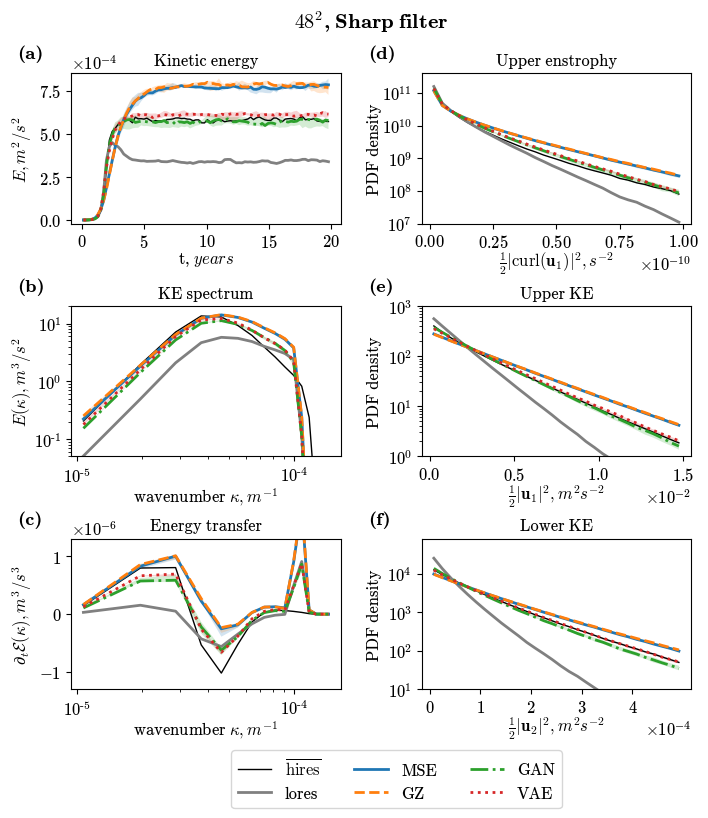

In [30]:
plot_online()
plt.suptitle('$48^2$, Sharp filter', y=0.96, fontweight='bold')
plt.savefig('figures/online_retrain_7200.pdf')

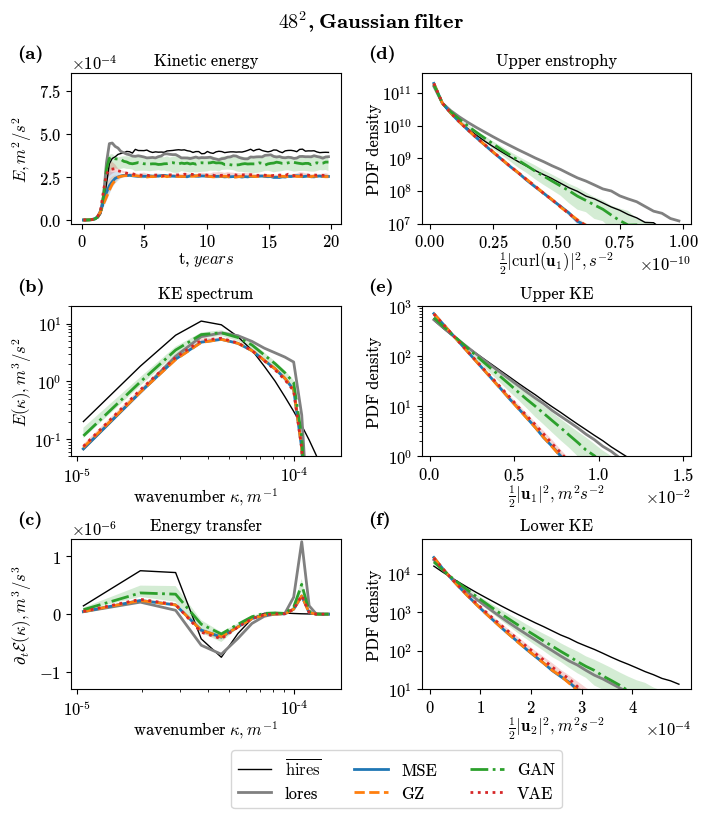

In [31]:
plot_online(operator='Operator2', exp='eddy-constant-0', ref='reference_48')
plt.suptitle('$48^2$, Gaussian filter', y=0.96, fontweight='bold')
plt.savefig('figures/online_retrain_14400_Gauss.pdf')

## Additional figures

Text(0.5, 0.96, '$64^2$, Sharp filter')

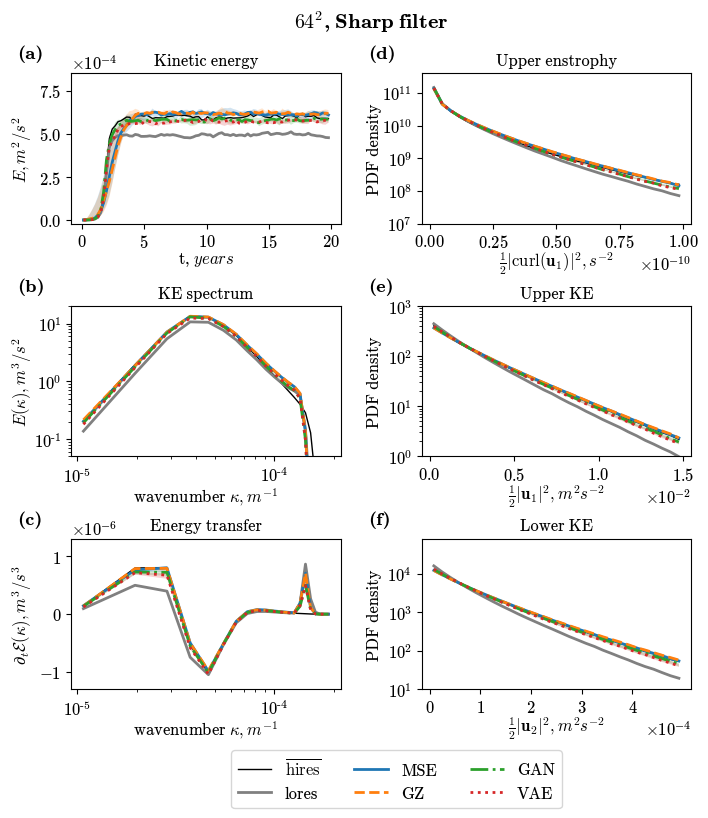

In [32]:
plot_online(resolution=64, exp='eddy-constant-0', ref='reference_64')
plt.suptitle('$64^2$, Sharp filter', y=0.96, fontweight='bold')

Text(0.5, 0.96, '$64^2$, Gaussian filter')

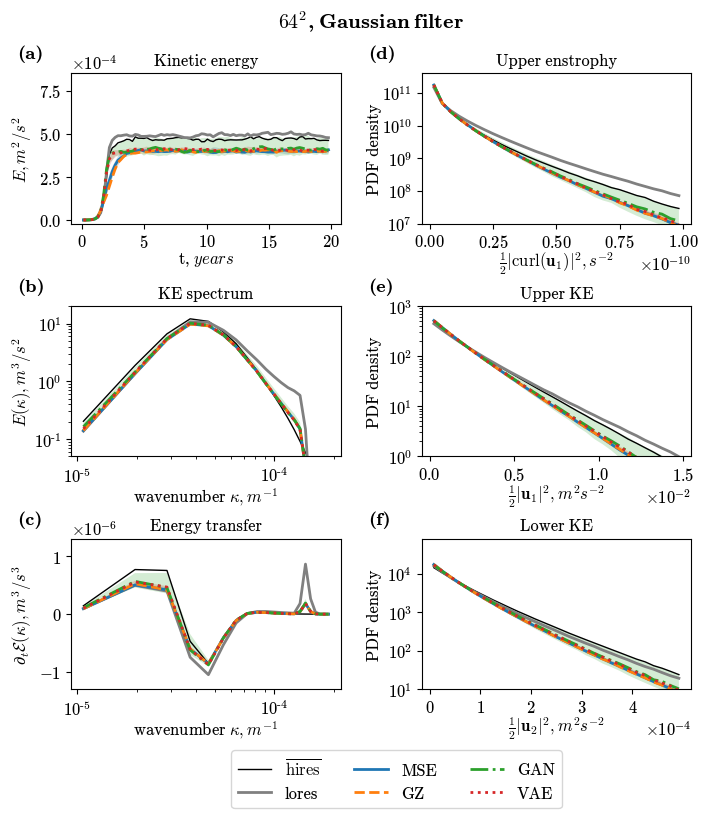

In [33]:
plot_online(resolution=64, operator='Operator2', exp='eddy-constant-0', ref='reference_64')
plt.suptitle('$64^2$, Gaussian filter', y=0.96, fontweight='bold')

Text(0.5, 0.96, '$96^2$, Sharp filter')

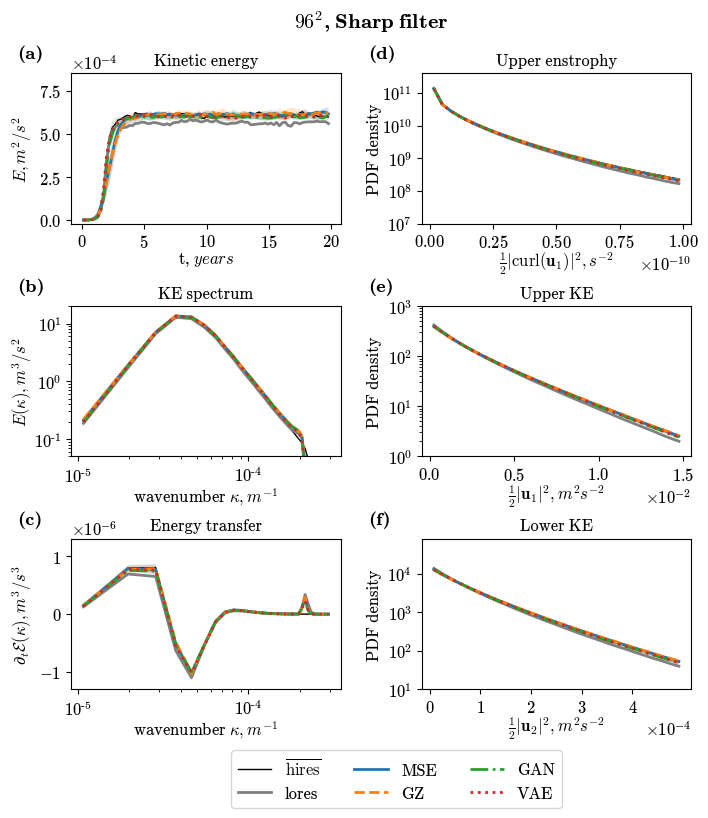

In [34]:
plot_online(resolution=96, exp='eddy-constant-0', ref='reference_96')
plt.suptitle('$96^2$, Sharp filter', y=0.96, fontweight='bold')

Text(0.5, 0.96, '$96^2$, Gaussian filter')

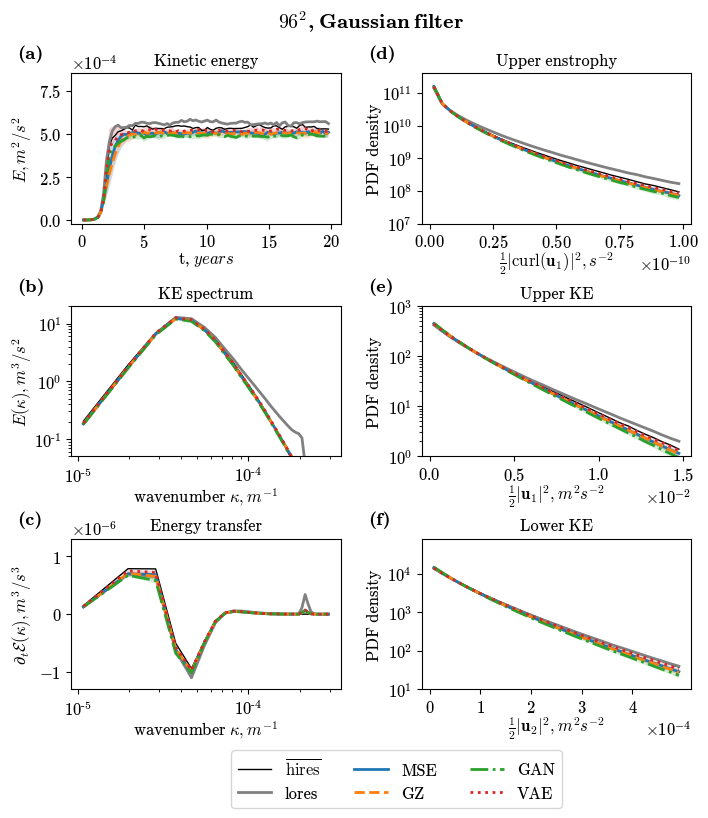

In [35]:
plot_online(resolution=96, operator='Operator2', exp='eddy-constant-0', ref='reference_96')
plt.suptitle('$96^2$, Gaussian filter', y=0.96, fontweight='bold')

# Snapshot two time steps

In [37]:
def read_experiment(model='OLSModel', model_num=0, resolution=64, operator='Operator1', exp='eddy-7200-constant-0', read_cache=True, delta=0.25):
    folder = os.path.join('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain', operator+'-'+str(resolution),model+'-'+str(model_num),exp)
    path = os.path.join(folder,'[0-9].nc')

    keyphrase = 'Warning: CFL>1. Computations are stopped.'
    err = os.path.join(folder, '*err*')
    os.system(f'cat {err} | grep "{keyphrase}"')

    ds = dataset_smart_read(path, read_cache=read_cache, delta=delta)
    return ds.isel(time=slice(0,None,2))

In [38]:
mse = read_experiment(model='OLSModel', model_num=1, resolution=48, operator='Operator1', exp='eddy-7200-constant-0', read_cache=False, delta=0.25)
mse_3600 = read_experiment(model='OLSModel', model_num=1, resolution=48, operator='Operator1', exp='eddy-3600-constant-0', read_cache=False, delta=0.25)


In [39]:
gz = read_experiment(model='MeanVarModel', model_num=1, resolution=48, operator='Operator1', exp='eddy-7200-constant-0', read_cache=False, delta=0.25)
gz_3600 = read_experiment(model='MeanVarModel', model_num=1, resolution=48, operator='Operator1', exp='eddy-3600-constant-0', read_cache=False, delta=0.25)


In [40]:
gan = read_experiment(model='CGANRegression-retrain', model_num=1, resolution=48, operator='Operator1', exp='eddy-7200-constant-0', read_cache=False, delta=0.25)
gan_3600 = read_experiment(model='CGANRegression-retrain', model_num=1, resolution=48, operator='Operator1', exp='eddy-3600-constant-0', read_cache=False, delta=0.25)


In [41]:
vae = read_experiment(model='CVAERegression-None', model_num=1, resolution=48, operator='Operator1', exp='eddy-7200-constant-0', read_cache=False, delta=0.25)
vae_3600 = read_experiment(model='CVAERegression-None', model_num=1, resolution=48, operator='Operator1', exp='eddy-3600-constant-0', read_cache=False, delta=0.25)


In [42]:
hires = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', delta=0.25, read_cache=True).isel(time=slice(0,None,2))
target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc', delta=0.25, read_cache=True).isel(time=slice(0,None,2))
coarse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_7200_48/[0-9].nc', delta=0.25, read_cache=True).isel(time=slice(0,None,2))

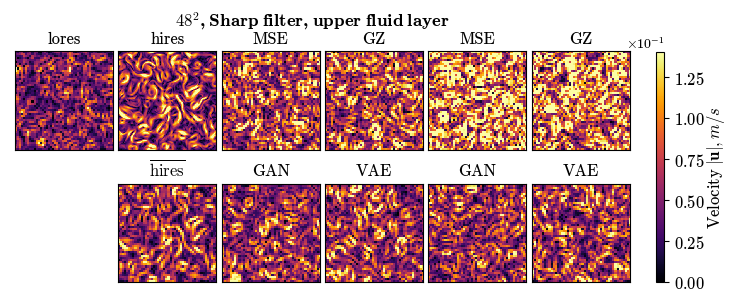

In [43]:
default_rcParams({'axes.titlesize': 12, 'axes.labelsize': 12, 'axes.formatter.limits': (-1,2)})

var = 'Vabs'
cmap = 'inferno'
lev=0
vmax=1.4e-1
#vmax = 3e-2
#lev = 1

idx = dict(run=1,time=-1,lev=lev)
idxt = dict(run=4, time=-1, lev=lev, trial=3)
models = [coarse,hires, mse, gz, mse_3600, gz_3600, None, target, gan ,vae, gan_3600, vae_3600]
labels = ['lores', 'hires', 'MSE','GZ', 'MSE','GZ', None, '$\overline{\mathrm{hires}}$', 'GAN', 'VAE', 'GAN', 'VAE']

fig, axs = plt.subplots(2,6,figsize=(8,3))
plt.subplots_adjust(hspace=0.35, wspace=0)
for j, m in enumerate(models):
    ax = axs[0 if j<6 else 1][j if j<6 else j-6]
    try:
        if 'trial' in m.dims:
            i = idxt
        else:
            i = idx
        im = imshow(m[var].isel(i), cmap=cmap, vmax=vmax, ax=ax, cbar=False)
        ax.set_title(labels[j], loc='center')
    except:
        ax.remove()
        
cbar = plt.colorbar(im, cax=fig.add_axes([0.93,0.11,0.01,0.767]), label='Velocity $|\mathbf{u}|, m/s$')
cbar.ax.tick_params(labelsize=12)
fig.suptitle('$48^2$, Sharp filter, upper fluid layer', y=1.02, fontweight='bold')
#set_letters(x=0, y=1.1)
plt.savefig(f'figures/online_7200_3600_snapshot_retrain.pdf')

# Show distribution error

In [44]:
import json
distance = {}
i = 0
for file in glob.glob('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/*.json'):
    i += 1
#    print(i, file)
    with open(file, 'r') as f:
        d = json.load(f)
        key = d.pop('key')
        distance[key] = d

In [45]:
distance['Operator1-48/MeanVarModel-3/eddy-constant-0']

{'distrib_diff_q1': 0.11030818166181357,
 'distrib_diff_q2': 0.005073390477163074,
 'distrib_diff_u1': 0.1301136518225767,
 'distrib_diff_u2': 0.12760272556835672,
 'distrib_diff_v1': 0.11679716715940658,
 'distrib_diff_v2': 0.11916222384736747,
 'distrib_diff_KE1': 0.20774505110466845,
 'distrib_diff_KE2': 0.21539863668616321,
 'distrib_diff_Ens1': 0.2784369493128419,
 'distrib_diff_Ens2': 0.22139339671011937,
 'spectral_diff_KEspec1': 0.32714906580489106,
 'spectral_diff_KEspec2': 0.2867964319610883,
 'spectral_diff_Eflux': 0.591061012095034,
 'spectral_diff_APEgenspec': 0.09811500304347157}

### Format of keys:
Operator1-48/OLSModel-0/eddy-3600-constant-0

In [47]:
def line_timestep(operator='Operator1', res=48, model='OLSModel', conf='eddy', fun=distrib_score):
    dt_key = ['-3600', '-7200', '', '-28800']
    dt = [1, 2, 4, 8]
    data = xr.DataArray(np.nan * np.zeros((4,5)), dims=['dt', 'trial'], coords={'dt': dt})
    for i, key in enumerate(dt_key):
        for j in range(5):
            if res==48 and operator == 'Operator1' and model in ['OLSModel', 'MeanVarModel', 'CGANRegression'] and j==3:
                continue
            if res==64 and operator == 'Operator1' and model in ['CVAERegression-None'] and j in [2,3]:
                continue
                
            data[i][j] = fun(distance[f'{operator}-{str(res)}/{model}-{str(j)}/{conf}{key}-constant-0'])
    return data
        

In [48]:
def line_timestep_ref(operator='Operator1', res=48, model='Reference', conf='eddy', fun=distrib_score):
    dt_key = ['-3600', '-7200', '', '-28800']
    dt = [1, 2, 4, 8]
    data = xr.DataArray(np.nan * np.zeros((4)), dims=['dt'], coords={'dt': dt})
    for i, key in enumerate(dt_key):
            data[i] = fun(distance[f'{operator}-{str(res)}/{model}/{conf}{key}'])
    return data

In [49]:
def line_resolution(operator='Operator1', model='OLSModel', conf='eddy', fun=distrib_score):
    res = [48, 64, 96]
    data = xr.DataArray(np.nan * np.zeros((3,5)), dims=['res', 'trial'], coords={'res': res})
    
    for i, r in enumerate(res):
        for j in range(5):
            if r==48 and operator == 'Operator1' and model in ['OLSModel', 'MeanVarModel', 'CGANRegression'] and j==3:
                continue
            if r==64 and operator == 'Operator1' and model in ['CVAERegression-None'] and j in [2,3]:
                continue
                
            data[i][j] = fun(distance[f'{operator}-{str(r)}/{model}-{str(j)}/{conf}-constant-0'])
    return data

In [50]:
def line_resolution_ref(operator='Operator1', model='Reference', conf='eddy', fun=distrib_score):
    res = [48, 64, 96]
    data = xr.DataArray(np.nan * np.zeros((3)), dims=['res'], coords={'res': res})
    
    for i, r in enumerate(res):                
        data[i] = fun(distance[f'{operator}-{str(r)}/{model}/{conf}'])
    return data

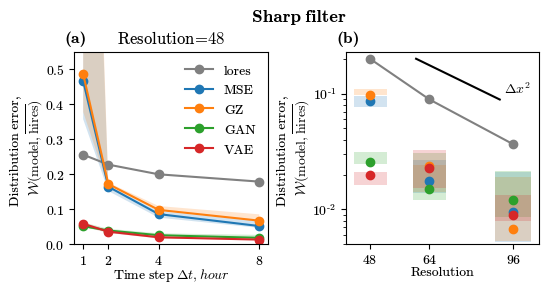

In [54]:
mse_time = line_timestep(model='OLSModel')
gz_time = line_timestep(model='MeanVarModel')
gan_time = line_timestep(model='CGANRegression-retrain')
vae_time = line_timestep(model='CVAERegression-None')
lores_time = line_timestep_ref()

mse_res = line_resolution(model='OLSModel')
gz_res = line_resolution(model='MeanVarModel')
gan_res = line_resolution(model='CGANRegression-retrain')
vae_res = line_resolution(model='CVAERegression-None')
lores_res = line_resolution_ref()

default_rcParams({'axes.formatter.limits': (-2,2)})
plt.figure(figsize=(6,2.5))
plt.subplots_adjust(hspace=0.0, wspace=0.4)
plt.subplot(1,2,1)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['MSE', 'GZ', 'GAN', 'VAE']
lores_time.plot(marker='o', color='gray', label='lores')
for j, m in enumerate([mse_time, gz_time, gan_time, vae_time]):
    m.median('trial').plot(marker='o', label=labels[j], color=colors[j])
    plt.fill_between(m['dt'], m.min('trial'), m.max('trial'), color=colors[j], alpha=0.2, edgecolor=None)
plt.xticks([1,2,4,8])
plt.ylim([0,0.55])
plt.legend(frameon=False)
plt.xlabel('Time step $\Delta t, hour$')
plt.title('Resolution=$48$')
plt.ylabel('Distribution error, \n $\mathcal{W}(\mathrm{model}, \overline{\mathrm{hires}})$')

plt.subplot(1,2,2)
lores_res.plot(marker='o', color='gray')
for j, m in enumerate([mse_res, gz_res, gan_res, vae_res]):
    m.median('trial').plot(marker='o', label=labels[j], color=colors[j], ls='')
    for r in m['res']:
        if r == 48:
            rr = [r-3.5,r+4]
        elif r==64:
            rr = [r-5,r+5.5]
        elif r==96:
            rr = [r-8,r+8.5]
        plt.fill_between(rr, [m.min('trial').sel(res=r)]*2,[m.max('trial').sel(res=r)]*2, color=colors[j], alpha=0.2, edgecolor=None)
#    plt.fill_between(m['res'], m.min('trial'), m.max('trial'), color=colors[j], alpha=0.2, edgecolor=None, step='mid')
y0 = 0.2
r = np.linspace(60,90,4)
plt.plot(r, y0*(r/r[0])**(-2.), color='k')
plt.text(92,0.1,'$\Delta x^{2}$')
plt.yscale('log')
plt.xscale('log')
plt.xticks([48, 64, 96], ['48', '64', '96'])
plt.minorticks_off()
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
plt.gca().yaxis.set_minor_locator(locmin)
plt.ylim([0.005, 0.23])
plt.xlabel('Resolution')
plt.ylabel('Distribution error, \n $\mathcal{W}(\mathrm{model}, \overline{\mathrm{hires}})$')

set_letters(x=-0.05)
plt.suptitle('Sharp filter', y=1.05, fontweight='bold')
plt.savefig('figures/online_distrib_retrain.pdf')

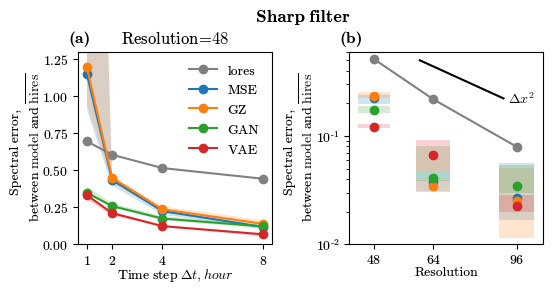

In [55]:
mse_time = line_timestep(model='OLSModel', fun=spectral_score)
gz_time = line_timestep(model='MeanVarModel', fun=spectral_score)
gan_time = line_timestep(model='CGANRegression-retrain', fun=spectral_score)
vae_time = line_timestep(model='CVAERegression-None', fun=spectral_score)
lores_time = line_timestep_ref(fun=spectral_score)

mse_res = line_resolution(model='OLSModel', fun=spectral_score)
gz_res = line_resolution(model='MeanVarModel', fun=spectral_score)
gan_res = line_resolution(model='CGANRegression-retrain', fun=spectral_score)
vae_res = line_resolution(model='CVAERegression-None', fun=spectral_score)
lores_res = line_resolution_ref(fun=spectral_score)

default_rcParams({'axes.formatter.limits': (-2,2)})
plt.figure(figsize=(6,2.5))
plt.subplots_adjust(hspace=0.0, wspace=0.4)
plt.subplot(1,2,1)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['MSE', 'GZ', 'GAN', 'VAE']
lores_time.plot(marker='o', color='gray', label='lores')
for j, m in enumerate([mse_time, gz_time, gan_time, vae_time]):
    m.median('trial').plot(marker='o', label=labels[j], color=colors[j])
    plt.fill_between(m['dt'], m.min('trial'), m.max('trial'), color=colors[j], alpha=0.2, edgecolor=None)
plt.xticks([1,2,4,8])
plt.ylim([0,1.3])
plt.legend(frameon=False)
plt.xlabel('Time step $\Delta t, hour$')
plt.title('Resolution=$48$')
plt.ylabel('Spectral error,  \n between $\mathrm{model}$ and $\overline{\mathrm{hires}}$')

plt.subplot(1,2,2)
lores_res.plot(marker='o', color='gray')
for j, m in enumerate([mse_res, gz_res, gan_res, vae_res]):
    m.median('trial').plot(marker='o', label=labels[j], color=colors[j], ls='')
    for r in m['res']:
        if r == 48:
            rr = [r-3.5,r+4]
        elif r==64:
            rr = [r-5,r+5.5]
        elif r==96:
            rr = [r-8,r+8.5]
        plt.fill_between(rr, [m.min('trial').sel(res=r)]*2,[m.max('trial').sel(res=r)]*2, color=colors[j], alpha=0.2, edgecolor=None)
#    plt.fill_between(m['res'], m.min('trial'), m.max('trial'), color=colors[j], alpha=0.2, edgecolor=None)

y0 = 0.5
r = np.linspace(60,90,4)
plt.plot(r, y0*(r/r[0])**(-2.), color='k')
plt.text(92,0.2,'$\Delta x^{2}$')
plt.yscale('log')
plt.xscale('log')
plt.gca().tick_params(axis='x', which='minor', bottom='off')
plt.xticks([48, 64, 96], ['48', '64', '96'])
plt.minorticks_off()
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
plt.gca().yaxis.set_minor_locator(locmin)
plt.ylim([0.01, 0.6])
plt.xlabel('Resolution')
plt.ylabel('Spectral error,  \n between $\mathrm{model}$ and $\overline{\mathrm{hires}}$')

set_letters(x=-0.05)
plt.suptitle('Sharp filter', y=1.05, fontweight='bold')
plt.savefig('figures/online_spectral_retrain.pdf')

# Amplitude-dependence

In [56]:
def KE(_ds):
    ds = _ds.isel(time=slice(44,None))
    return float(ave_lev(0.5*(ds.u**2 + ds.v**2), delta=0.25).mean(('run', 'x', 'y', 'time')))

In [57]:
def line_amplitude(model='OLSModel-0', res=48, operator='Operator1', lores_KE=0):
    amps = [0.0, 0.5, 0.65, 0.8, 0.9, 1.0, 1.1, 1.2, 1.35, 1.5]
    data = xr.DataArray(np.nan*np.zeros(10), dims=['amp'], coords=[amps])
    
    for j, amp in enumerate(amps):
        if j == 0:
            data[j] = lores_KE
        else:
            try:
                data[j] = KE(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/{operator}-{str(res)}/{model}/{str(amp)}-eddy-constant-0/[0-9].nc', combine='nested', concat_dim='run'))
            except:
                pass
        
    return data

In [58]:
lores = KE(xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc', combine='nested', concat_dim='run'))

In [59]:
mse_op1 = line_amplitude('OLSModel-0', lores_KE=lores)
gz_op1 = line_amplitude('MeanVarModel-0', lores_KE=lores)
gan_op1 = line_amplitude('CGANRegression-retrain-0', lores_KE=lores)
vae_op1 = line_amplitude('CVAERegression-None-0', lores_KE=lores)

In [60]:
mse_op2 = line_amplitude('OLSModel-0', operator='Operator2', lores_KE=lores)
gz_op2 = line_amplitude('MeanVarModel-0', operator='Operator2', lores_KE=lores)
gan_op2 = line_amplitude('CGANRegression-retrain-0', operator='Operator2', lores_KE=lores)
vae_op2 = line_amplitude('CVAERegression-None-0', operator='Operator2', lores_KE=lores)

In [61]:
hires_op1 = 0*mse_op1['amp'] + KE(xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc', combine='nested', concat_dim='run'))
hires_op2 = 0*mse_op1['amp'] + KE(xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc', combine='nested', concat_dim='run'))

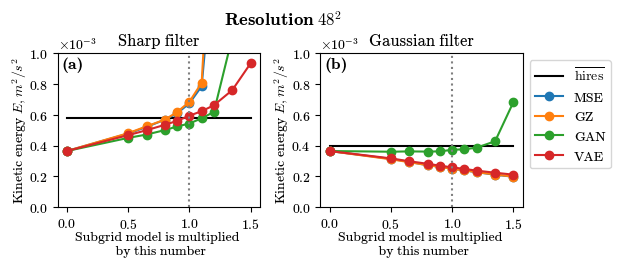

In [63]:
default_rcParams({'axes.formatter.limits': (-2,2)})
plt.figure(figsize=(6,2))

label=['MSE', 'GZ', 'GAN', 'VAE']

plt.subplot(1,2,1)
hires_op1.plot(color='k', label='$\overline{\mathrm{hires}}$')
for j, m in enumerate([mse_op1, gz_op1, gan_op1, vae_op1]):
    m.plot(marker='o', label=label[j])
plt.xlabel('Subgrid model is multiplied \n by this number')
plt.ylabel('Kinetic energy $E, m^2/s^2$')
plt.ylim([0, 1e-3])
plt.axvline(x=1, ls=':', color='gray')
plt.title('Sharp filter')
    
plt.subplot(1,2,2)
hires_op2.plot(color='k', label='$\overline{\mathrm{hires}}$')
for j, m in enumerate([mse_op2, gz_op2, gan_op2, vae_op2]):
    m.plot(marker='o', label=label[j])
plt.xlabel('Subgrid model is multiplied \n by this number')
plt.ylabel('Kinetic energy $E, m^2/s^2$')
plt.ylim([0, 1e-3])
plt.axvline(x=1, ls=':', color='gray')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Gaussian filter')
set_letters(x=0.02, y=0.9)
plt.suptitle('Resolution $48^2$', y=1.1, fontweight='bold')
plt.savefig('figures/amp_sensitivity.pdf')

In [132]:
hires_op1

<xarray.DataArray (amp: 10)>
array([0.00058004, 0.00058004, 0.00058004, 0.00058004, 0.00058004,
       0.00058004, 0.00058004, 0.00058004, 0.00058004,        nan])
Coordinates:
  * amp      (amp) float64 0.0 0.5 0.65 0.8 0.9 1.0 1.1 1.2 1.35 1.5

# Sensetivity to time step

In [73]:
def get_dataset(nx=64, dt=3600):
    time_prefix = '_'+str(dt) if dt is not None else ''
    
    return dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference{time_prefix}_{str(nx)}/[0-9].nc', delta=0.25)            

In [90]:
ds = {}
Nx = 48
for dt in [28800, None, 3600, 600, 60]:
    ds[dt] = get_dataset(Nx, dt)
label = {60: '$\Delta t=1 min$', 600: '$\Delta t=10 mins$', 3600: '$\Delta t=1 hour$', None: '$\Delta t=4 hours$', 28800: '$\Delta t=8 hours$'}
colors = ['0.2', '0.3', '0.4', '0.5', '0.6']
hires = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', delta=0.25)            

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_28800_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_60_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc


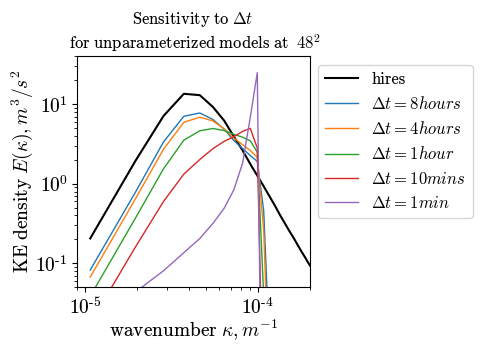

In [104]:
default_rcParams({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 12,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 12
})
plt.figure(figsize=(3,3))
(0.5*hires.KEspecr_mean).plot(color='k', label='hires')
for key, color in zip(ds.keys(), colors):
    (0.5*ds[key].KEspecr_mean).plot(lw=1, label=label[key])
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-2, 4e+1])
plt.ylabel('KE density $E(\kappa), m^3/s^2$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
plt.title('Sensitivity to $\Delta t$ \n for unparameterized models at  $48^2$', loc='center')
plt.xlim([0.9e-5, 2e-4])
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('paper_figures_1/time_step_sensetivity.pdf')

# Generalization to jet

In [2]:
def read_line(model='OLSModel', model_num=0, resolution=48, operator='Operator1', exp='jet-7200-constant-0'):
    ds = []
    t_length = []
    for ens in range(10):
        path = f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/{operator}-{str(resolution)}/{model}-{str(model_num)}/{exp}/{str(ens)}.nc'
        ds.append(xr.open_dataset(path, decode_times=False)[['u','v','q']])
        t_length.append(len(ds[-1].time))
    
    tmin = np.array(t_length).min()
    for j in range(len(ds)):
        ds[j] = ds[j].isel(time=slice(tmin))
        
    def KE(ds):
        return (ds.u**2 + ds.v**2) * 0.5
    def KE_time(ds):
        return ave_lev(KE(ds), delta=0.1).mean(('x', 'y', 'run'))
            
    ds = xr.concat(ds, dim='run')
    ds['time'] = ds['time'] / 360
    
    ds['KE_time'] = KE_time(ds)
    ds['KE'] = KE(ds)
    
    return ds

In [3]:
def read_trials(**kw):
    ds = []
    t_length = []
    for j in range(5):
        if j>4:
            if kw['model'] in ['CVAERegression-None'] and kw['resolution']==64:
                pass
            else:
                continue
        if kw['resolution']==48 and kw['operator'] == 'Operator1' and kw['model'] in ['OLSModel', 'MeanVarModel', 'CGANRegression'] and j==3:
            continue
        if kw['resolution']==64 and kw['operator'] == 'Operator1' and kw['model'] in ['CVAERegression-None'] and j in [2,3]:
            continue

        ds.append(read_line(model_num=j, **kw))
        t_length.append(len(ds[-1].time))

    tmin = np.array(t_length).min()
    ds = xr.concat(ds, dim='trial')

    ds['KE_time_median'] = ds['KE_time'].isel(time=slice(tmin)).median('trial')
    ds['KE_time_min'] = ds['KE_time'].isel(time=slice(tmin)).min('trial')
    ds['KE_time_max'] = ds['KE_time'].isel(time=slice(tmin)).max('trial')
    ds['time_trial'] = ds['time'].isel(time=slice(tmin))
    
    return ds.isel(time=slice(None,None,2))

In [4]:
def read_target(resolution=48, operator='Operator1'):
    return dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/{operator}-{str(resolution)}.nc', delta=0.1, read_cache=False).isel(time=slice(None,None,2))

In [5]:
def read_coarse(resolution=48, operator='Operator1'):
    return dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_{str(resolution)}/[0-9].nc', delta=0.1, read_cache=False).isel(time=slice(None,None,2))

In [6]:
mse = []
gz = []
gan = []
vae = []
target = []
coarse = []

for resolution in [48, 64, 96]:
    mse.append(read_trials(resolution=resolution, operator='Operator1', model='OLSModel'))
    gz.append(read_trials(resolution=resolution, operator='Operator1', model='MeanVarModel'))
    gan.append(read_trials(resolution=resolution, operator='Operator1', model='CGANRegression-retrain'))
    vae.append(read_trials(resolution=resolution, operator='Operator1', model='CVAERegression-None'))
    target.append(read_target(resolution=resolution, operator='Operator1'))
    coarse.append(read_coarse(resolution=resolution, operator='Operator1'))    

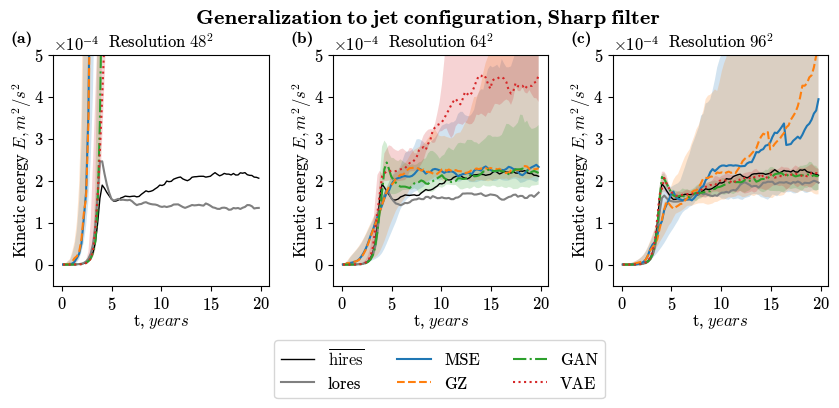

In [7]:
default_rcParams({
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'lines.linewidth': 1.5
})
plt.figure(figsize=(10,3))
labels = ['MSE', 'GZ', 'GAN', 'VAE']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
ls = ['-', '--', '-.', ':']
title = ['Resolution $48^2$', 'Resolution $64^2$', 'Resolution $96^2$']
for col in range(3):    
    plt.subplot(1,3,col+1)
    target[col].KE_time.plot(color='k', ls='-', lw=1, label=r'$\overline{\mathrm{hires}}$')
    coarse[col].KE_time.plot(color='gray', label='lores')
    for j, m in enumerate([mse[col], gz[col], gan[col], vae[col]]):
        m.KE_time.median('trial').plot(color=colors[j], ls=ls[j], label=labels[j])
        plt.fill_between(m['time'], m.KE_time.min('trial'), m.KE_time.max('trial'), color=colors[j], alpha=0.2, edgecolor=None)
    
    plt.ylim([-0.05e-3, 0.5e-3])
    plt.xticks([0,5,10,15,20])
    plt.ylabel(r'Kinetic energy $E, m^2/s^2$')
    plt.xlabel('t, $years$')
    plt.title(title[col])
plt.suptitle('Generalization to jet configuration, Sharp filter', y=1.03, fontweight='bold')
set_letters()
plt.legend(bbox_to_anchor=(0,-0.2), ncol=3)
plt.savefig('figures/jet_generalization_retrain.pdf')

# Additional training information

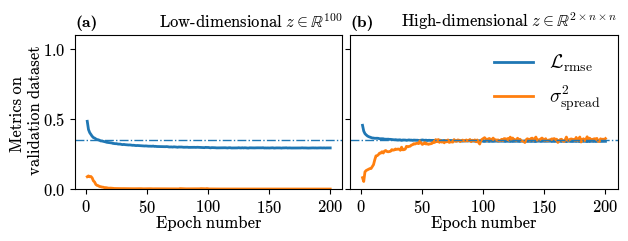

In [14]:
default_rcParams({
    'axes.titlelocation' : 'right', 
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.formatter.limits': (-2,3),})
stats_none = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_loss/Operator1-48/CVAEBottleneck-0/model/stats.nc')
stats_correction = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_loss/Operator1-48/CVAERegression-KL-0/model/stats.nc')

fig, axs = plt.subplots(1,2, figsize=(7,2))
plt.subplots_adjust(wspace=0.03)

ax = axs[0]
stats_none.L2_mean_test.plot(ax=ax, lw=2)
stats_none.var_ratio.mean('lev').plot(ax=ax, lw=2)
ax.set_xlabel('Epoch number')
ax.set_ylabel('Metrics on \n validation dataset')
ax.set_ylim([0, 1.1])
ax.set_title('Low-dimensional $z \in \mathbb{R}^{100}$')

ax = axs[1]
stats_correction.L2_mean_test.plot(ax=ax, lw=2, label='$\mathcal{L}_{\mathrm{rmse}}$')
stats_correction.var_ratio.mean('lev').plot(ax=ax, lw=2, label='$\sigma^2_{\mathrm{spread}}$')
ax.set_xlabel('Epoch number')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('High-dimensional $z \in \mathbb{R}^{2 \\times n \\times n}$')
ax.set_ylim([0, 1.1])
ax.legend(frameon=False, fontsize=14)

for ax in axs:
    ax.axhline(y=stats_correction.L2_mean_test.sel(epoch=50), ls='-.', lw=1, color='#1f77b4')
    
set_letters(x=0)


plt.savefig('figures/training_VAE.pdf', bbox_inches='tight')